In [1]:

import os
import sys
import random
import pandas as pd
import numpy as np
#import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [2]:
from keras.layers import add, ConvLSTM2D, Reshape, Dense, AveragePooling2D, Input, Conv2DTranspose, TimeDistributed, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import add, Reshape, Dense, Input, TimeDistributed, Dropout, Activation, LSTM, Conv1D, Cropping1D,GRU
from keras.layers import MaxPooling1D, UpSampling1D, Cropping1D, SpatialDropout1D, Bidirectional, BatchNormalization 
from keras.models import Model, Sequential
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.optimizers import Adam
import matplotlib

In [3]:
#时域模态信息

import scipy.io as scio
import pandas as pd

#1 input
feature1 = r'\时域1-5s\ACC_EW.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_EW']
A=AA[:,0:400]

feature2 = r'\时域1-5s\ACC_NS.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_NS']
B=BB[:,0:400]

feature3 = r'\时域1-5s\ACC_UD.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_UD']
C=CC[:,0:400]


raw_data1=np.hstack((A,B))
x_data=np.hstack((raw_data1,C))

print(x_data.shape)



(53286, 1200)


In [4]:
#频域模态信息

import scipy.io as scio
import pandas as pd

#input
feature1s = r'\频域\3s\spec_EW.mat'
data1s = scio.loadmat(feature1s)
AAs=data1s['spec_EW']
As=AAs[:,0:200]

feature2s = r'\频域\3s\spec_NS.mat'
data2s = scio.loadmat(feature2s)
BBs=data2s['spec_NS']
Bs=BBs[:,0:200]

feature3s = r'\频域\3s\spec_UD.mat'
data3s = scio.loadmat(feature3s)
CCs=data3s['spec_UD']
Cs=CCs[:,0:200]

raw_data1s=np.hstack((As,Bs))
x_datas=np.hstack((raw_data1s,Cs))

print(x_datas.shape)



(53286, 600)


In [5]:
#特征模态信息

import scipy.io as scio
import pandas as pd

label = pd.read_csv(open(r'\特征模态信息3s.csv',encoding='UTF-8'))
y_data=label.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values  #特征嵌入
print(y_data[0])
print(y_data.shape)

[0.01591836 0.06319288 1.28865615 0.00216419 1.30908207 0.00139702
 0.1574331  0.30811366 0.00250608 1.        ]
(53286, 10)


In [6]:
from sklearn.model_selection import train_test_split  #random_state=21  24  26  27  65
#时域划分
train_xxt, test_xxt, train_y1, test_y1 = train_test_split(x_data, y_data, test_size=0.2, random_state=30) 
#频域划分
train_xxs, test_xxs, train_y1, test_y1 = train_test_split(x_datas, y_data, test_size=0.2, random_state=30) 

In [7]:
train_y=train_y1[:,[9]]
train_feature=train_y1[:,[0,1,2,3,4,5,6,7,8]]
print(train_y.shape)
print(train_y[1])

print(train_feature.shape)
print(train_feature[1])


test_y=test_y1[:,[9]]
test_feature=test_y1[:,[0,1,2,3,4,5,6,7,8]]
print(test_y.shape)
print(test_y[1])

print(test_feature.shape)
print(test_feature[1])


(42628, 1)
[1.]
(42628, 9)
[7.6042600e-04 3.7566390e-03 8.8836015e-02 2.4579300e-05 1.3273381e-01
 1.1320200e-05 2.7224624e-01 2.6569918e-01 2.0702300e-04]
(10658, 1)
[2.]
(10658, 9)
[0.02253614 0.07986302 0.60228547 0.04616989 1.73744674 0.00363566
 1.52385847 0.83315002 0.03434189]


In [8]:
#时域模态 训练
train_xt=[]
for i in range(len(train_xxt)):
    train_xt.append(np.array(train_xxt[i].reshape(3,1,400)).T)

In [9]:
#时域模态 测试
test_xt=[]
for i in range(len(test_xxt)):
    test_xt.append(np.array(test_xxt[i].reshape(3,1,400)).T)

In [10]:
#频域模态 训练
train_xs=[]
for i in range(len(train_xxs)):
    train_xs.append(np.array(train_xxs[i].reshape(3,1,200)).T)


In [11]:
#频域模态 测试
test_xs=[]
for i in range(len(test_xxs)):
    test_xs.append(np.array(test_xxs[i].reshape(3,1,200)).T)

In [12]:
train_xt=np.array(train_xt)
test_xt=np.array(test_xt)

train_xs=np.array(train_xs)
test_xs=np.array(test_xs)

In [13]:
#3#  ##Reshaping
#时域
train_xt = np.reshape(train_xt, (train_xt.shape[0], 400, 3))
test_xt = np.reshape(test_xt, (test_xt.shape[0], 400, 3))
print("0",train_xt.shape[0])
print("1",train_xt.shape[1])
print(train_xt.shape)


#频域
train_xs = np.reshape(train_xs, (train_xs.shape[0], 200, 3))
test_xs = np.reshape(test_xs, (test_xs.shape[0], 200, 3))
print("0",train_xs.shape[0])
print("1",train_xs.shape[1])
print(train_xs.shape)



0 42628
1 400
(42628, 400, 3)
0 42628
1 200
(42628, 200, 3)


In [14]:
#from tensorflow import keras
from keras import backend as K
from keras.engine.topology import Layer

class Self_Attention(Layer):
 
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
 
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
 
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
 
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
 
 
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
 
        QK = QK / (64**0.5)
 
        QK = K.softmax(QK)
 
        print("QK.shape",QK.shape)
 
        V = K.batch_dot(QK,WV)
 
        return V
 
    def compute_output_shape(self, input_shape):
 
        return (input_shape[0],input_shape[1],self.output_dim)

In [15]:
seed=50
def Timedomain(x):
    
    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,

    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,
    
    
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458
    

    x = tf.keras.layers.Bidirectional(GRU(128,use_bias=True, return_sequences = True,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)    
    
    x = tf.keras.layers.Bidirectional(GRU(64,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458    
    
    return x

def Specdomain(x):
    
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    
    
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458

    x = tf.keras.layers.Bidirectional(GRU(64,use_bias=True, return_sequences = True,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    

    x = tf.keras.layers.Bidirectional(GRU(32,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458     
    
    
    return x

In [16]:
seed=50
drop_rate = 0.2
from tensorflow import keras
from keras.models import Model
def CRmodel():
    inpt1 = Input(shape=(400, 3), name='input_layer1') #时域
    inpt2 = Input(shape=(200, 3), name='input_layer2') #频域
    

    
    x1 = Timedomain(inpt1)
    
    x2 = Specdomain(inpt2)

    

    inpt3 = tf.keras.layers.Input(shape=(9,1))   #加入特征模态
    
    x3 = tf.keras.layers.Flatten()(inpt3) # 打平层，方便全连接层处理 

    concat = tf.keras.layers.Concatenate()([x1, x2, x3])

    e = Dense(64, activation='relu')(concat)#relu
    e = Dense(32, activation='relu')(e)
    e = Dense(3)(e)
    oupts = Activation('softmax', name='output_layer')(e)

#    
    model=Model(inputs=[inpt1,inpt2,inpt3], outputs=oupts)
    #model=Model(inputs=inpt2, outputs=z)
    return model

In [17]:
#优点：由于DNN几乎可以拟合任何函数，所以DNN的非线性拟合能力非常强。往往深而窄的网络要更节约资源。
from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers


model = CRmodel()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       [(None, 400, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 128)     1280        input_layer1[0][0]               
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 200, 128)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
input_layer2 (InputLayer)       [(None, 200, 3)]     0                                            
_______________________________________________________________________________________

In [18]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [19]:
import time
import datetime
epochs=500  # how many passes through our data


lr_reducer = ReduceLROnPlateau(monitor='val_acc',
                               factor=0.1,
                                cooldown= 0,
                                patience= 5, #patience= 5
                                min_lr=0.5e-6) #min_lr=0.5e-6

early_stopping_monitor = EarlyStopping(monitor= 'val_acc', patience = 10) #patience = 45   10
callbacks = [lr_reducer, early_stopping_monitor]

rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=rms, loss=losses.sparse_categorical_crossentropy,metrics=["acc"])

history=model.fit([train_xt,train_xs,train_feature], train_y, epochs = epochs,batch_size = 256,shuffle=True,\
                  validation_split=0.1,callbacks=callbacks) #epochs = 20, batch_size = 64   ,class_weight=weights


Epoch 1/500
150/150 [==============================] - 23s 155ms/step - loss: 0.2081 - acc: 0.9177 - val_loss: 0.1049 - val_acc: 0.9615 3s - loss: 0.2252 - acc: 0.910 - ETA: 3s - loss: 0.2243 - acc: 0.911 - ETA: 2s - lo
Epoch 2/500
150/150 [==============================] - 29s 192ms/step - loss: 0.1152 - acc: 0.9549 - val_loss: 0.1027 - val_acc: 0.9599s: 0.1212 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0. - ETA: 19s - loss: 0.1206 - a - ETA: 18s - loss: 0.1187 - acc:  - ETA: 18s - loss:  - ETA: 16s - loss: 0.1164 - acc:  - ETA: 15s - loss: 0.1161 - ETA: 11s - loss: - ETA: 8s - loss: 0.1166 - acc: 0. - ETA: 7s - loss: 0.1172 - acc: 0.954 - ETA: 7s - loss: 0.1170 - a - ETA: 5s - loss: 0.1171 - a - ETA: 3s - loss: 0.1175 - acc: 0.954 - ETA: 3s - loss: 0.1175 - acc: 0.953 - ETA: 3s - loss: 0.1174 - acc:  - ETA: 2s - loss: 0.1168 - acc: 0.954 - ETA: 2s - loss: 0.1167 - a - ETA: 0s - loss: 0.1152 - acc: 0.9
Epoch 3/500
150/150 [==============================] - 29s 194ms/step - loss: 0.1

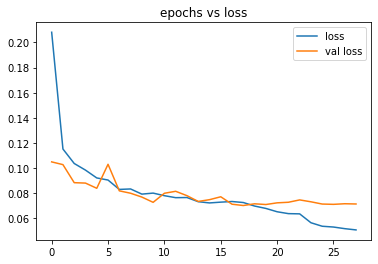

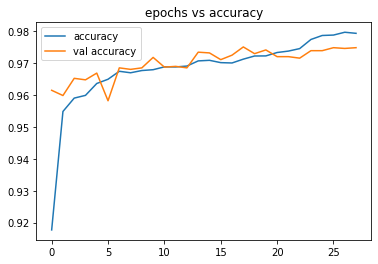

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

In [21]:
results_test = model.evaluate([test_xt,test_xs,test_feature], test_y)
results_train = model.evaluate([train_xt,train_xs,train_feature], train_y)
print(results_test)
print(results_train)

1333/1333 [==============================] - 22s 17ms/step - loss: 0.0469 - acc: 0.9824
[0.0672050416469574, 0.9745730757713318]
[0.04688149318099022, 0.982358992099762]


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.rcParams['font.sans-serif']=['times new roman'] #显示中文标签
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title,fontproperties='Times New Roman', size=12)
    cb=plt.colorbar()
    cb.set_label(label='Number of records',fontproperties='Times New Roman',size=10)
    cb.ax.tick_params(labelsize=10)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0,fontproperties='Times New Roman', size=10)
    plt.yticks(tick_marks, classes,fontproperties='Times New Roman', size=10)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],fontproperties='Times New Roman', size=10,
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label',fontproperties='Times New Roman', fontsize=10)
    plt.xlabel('Predicted label', fontproperties='Times New Roman',fontsize=10)

(42628, 3)
(42628,)
             precision    recall  f1-score   support

        0.0     0.9995    0.9990    0.9992     20803
        1.0     0.9767    0.9780    0.9773     16232
        2.0     0.9351    0.9331    0.9341      5593

avg / total     0.9824    0.9824    0.9824     42628



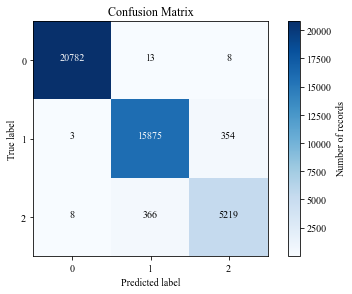

In [23]:
#Train result
predictions_train = model.predict([train_xt,train_xs,train_feature])
print(predictions_train.shape)
train_pre = np.argmax(predictions_train,axis = 1)
print(train_pre.shape)

#训练结果
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt   
import itertools
from sklearn.metrics import accuracy_score
cm=sklearn.metrics.confusion_matrix(train_y, train_pre)

plot_confusion_matrix(cm,classes=['0','1','2'],title='Confusion Matrix')


from sklearn.metrics import classification_report
print(classification_report(train_y, train_pre,digits=4))


In [ ]:
test_xt1=test_xt[0]
test_xt1=test_xt1.reshape(1, 400, 3)
test_xs1=test_xs[0]
test_xs1=test_xs1.reshape(1, 200, 3)
test_feature1=test_feature[0]
test_feature1=test_feature1.reshape(1,9)
print(test_xt1.shape)
print(test_xs1.shape)
print(test_feature1.shape)

In [65]:
#计算时间
#Test result


import time
start_time = time.perf_counter()  # 记录开始时间
predictions_test = model.predict([test_xt1,test_xs1,test_feature1])
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
#print(predictions_test)

Elapsed time: 53.13 ms


(10658, 3)
(10658,)
             precision    recall  f1-score   support

        0.0    0.99847   0.99923   0.99885      5210
        1.0    0.96820   0.96652   0.96736      4032
        2.0    0.90486   0.90678   0.90582      1416

avg / total    0.97458   0.97457   0.97458     10658

accuracy: 0.9745730906361418


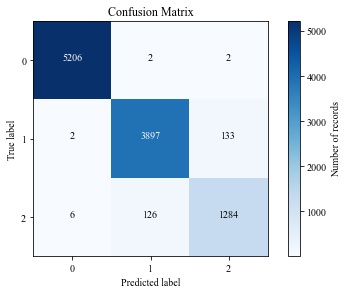

In [24]:
#Test result
predictions_test = model.predict([test_xt,test_xs,test_feature])
print(predictions_test.shape)
test_pre = np.argmax(predictions_test,axis = 1)
print(test_pre.shape)

#测试结果
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt   
import itertools
from sklearn.metrics import accuracy_score
cm=sklearn.metrics.confusion_matrix(test_y, test_pre)

plot_confusion_matrix(cm,classes=['0','1','2'],title='Confusion Matrix')


from sklearn.metrics import classification_report
print(classification_report(test_y, test_pre,digits=5))
from sklearn.metrics import accuracy_score
print("accuracy:",accuracy_score(test_y, test_pre))